<a href="https://colab.research.google.com/github/Ankan1998/Semantic-Segmentation/blob/main/Semantic_Segmentation_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Oct 11 18:02:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import zipfile
import torch
import torchvision
import matplotlib.pyplot as plt
import tensorboard
import numpy as np
from PIL import Image

### **Kaggle preparation**
##### Aerial dataset of kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=993fc13c7b1555c008f6b9d13b6066154d9de2d6e0aa85deeacf5b6fb2dda2f2
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset -p "/tmp"

100% 3.83G/3.83G [01:13<00:00, 48.7MB/s]
100% 3.83G/3.83G [01:13<00:00, 56.1MB/s]


In [ ]:
local_zip='/tmp/semantic-drone-dataset.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/content")
zip_ref.close()

### **Checking with one pair of image**

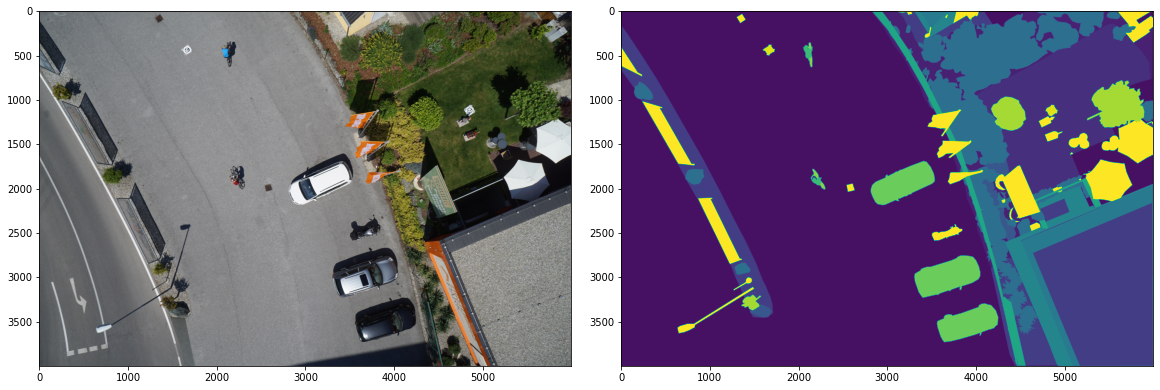

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

original_image = "/content/semantic_drone_dataset/original_images/004.jpg"
label_image_semantic = "/content/semantic_drone_dataset/label_images_semantic/004.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))

axs[1].imshow(Image.open(label_image_semantic))


In [ ]:
im = Image.open(label_image_semantic)
list(np.unique(np.array(im)))

[0, 1, 2, 3, 4, 6, 8, 9, 10, 13, 14, 15, 17, 18, 19, 21, 22]

In [ ]:
import cv2
 
img = cv2.imread('/content/semantic_drone_dataset/original_images/008.jpg', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('/content/semantic_drone_dataset/label_images_semantic/008.png')
dim = (256, 256)
# resize image
resized_mask = cv2.resize(mask, dim)
resized_img = cv2.resize(img, dim)

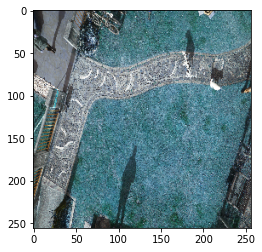

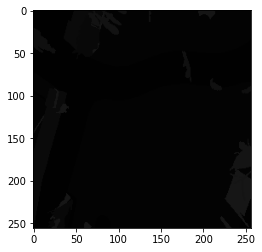

In [ ]:
plt.imshow(resized_img)
plt.show()
plt.imshow(resized_mask)
plt.show()

## **Constructing Custom dataset**

In [ ]:
from torch.utils.data import Dataset, DataLoader, sampler

In [ ]:
"""
def classes(mask_dir):
  mask_file=os.listdir(mask_dir)
  mask_class=[]
  for i in range(len(mask_file)):
    mask_name=os.path.join(mask_dir,mask_file[i])
    mask = Image.open(mask_name)
    mask_class.append(max(list(np.unique(np.array(mask)))))
    print(mask_class)
  return max(mask_class)

  
NUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")
"""

'\ndef classes(mask_dir):\n  mask_file=os.listdir(mask_dir)\n  mask_class=[]\n  for i in range(len(mask_file)):\n    mask_name=os.path.join(mask_dir,mask_file[i])\n    mask = Image.open(mask_name)\n    mask_class.append(max(list(np.unique(np.array(mask)))))\n    print(mask_class)\n  return max(mask_class)\n\n  \nNUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")\n'

In [ ]:
NUM_OF_CLASSES=26

In [ ]:
class Satellite_Dataset(Dataset):
    def __init__(self, img_dir,mask_dir,transform=None):
      self.img_dir=img_dir
      self.mask_dir=mask_dir
      self.img_file_list=sorted(os.listdir(img_dir))
      self.mask_file_list=sorted(os.listdir(mask_dir))
      self.transform = transform
        

    def __len__(self):
      return len(self.img_file_list)

    def __getitem__(self, index):
      img_name=os.path.join(self.img_dir, self.img_file_list[index])
      img = Image.open(img_name)
      mask_name=os.path.join(self.mask_dir, self.mask_file_list[index])
      mask = (Image.open(mask_name)).resize((256,256))
      mask=np.array(mask)
      if self.transform:
        img = self.transform(img)
        #mask = self.transform(mask)
      mask = torch.Tensor(mask).long()
      #mask=torch.squeeze(mask,0)
      return (img,mask)


In [ ]:
from torchvision import transforms
# change the directory accordingly
img_dir="/content/semantic_drone_dataset/original_images"
mask_dir="/content/semantic_drone_dataset/label_images_semantic"
transform_img = transforms.Compose([
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dataset = Satellite_Dataset(img_dir, mask_dir, transform= transform_img)

In [ ]:
len(dataset)

400

In [ ]:
x, y = dataset[7]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


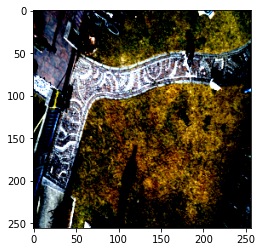

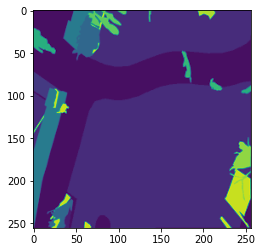

In [ ]:
# permuting to change to (256,256,3)
x=x.permute((1,2,0))
plt.imshow(x)
plt.show()
plt.imshow(y)

In [ ]:
# Splitting into train and val set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [350, 50])

In [ ]:
# passing into dataloader
train_dl = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size=12, shuffle=True)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 256, 256]), torch.Size([12, 256, 256]))

## **FCN model**

In [ ]:
import torchvision.models as models

In [ ]:
fcn_resnet_50=models.segmentation.fcn_resnet50(pretrained=False,progress=True, num_classes=NUM_OF_CLASSES)
#fcn_resnet_50=fcn_resnet_50.double()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device="cpu"
fcn_resnet_50=fcn_resnet_50.to(device)

In [ ]:
xb=xb.to(device)

In [ ]:
#bn = xb.squeeze(0)

In [ ]:
y=fcn_resnet_50(xb)['out']

In [ ]:
y.shape

torch.Size([12, 26, 256, 256])

In [ ]:
#loss function
loss=torch.nn.CrossEntropyLoss()

#optimizer
optimizer=torch.optim.Adam(fcn_resnet_50.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1)

In [ ]:
xb, yb = next(iter(train_dl))
yb.shape

torch.Size([12, 256, 256])

In [ ]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    c=0
    for images, labels in train_dl:
        # Flatten MNIST images into a 784 long vector
        #images = images.view(images.shape[0], -1)
        #images,labels=images.double(),labels.double()
        images,labels=images.to(device),labels.to(device)
        # Training pass
        #print(type(labels))
        optimizer.zero_grad()
        
        output = fcn_resnet_50(images)["out"]
        labels=labels.long()
        lossi = loss(output, labels)
        lossi.backward()
        optimizer.step()
        print(f"batch {c}, loss-->{lossi.item()}")
        c=c+1
        running_loss += lossi.item()
    print("*"*40)
    print(f"epoch {e}, loss-->{running_loss}")
    print("*"*40)


batch 0, loss-->3.5299856662750244
batch 1, loss-->2.778303384780884
batch 2, loss-->2.3813440799713135
batch 3, loss-->2.726087808609009
batch 4, loss-->2.0614473819732666
batch 5, loss-->1.8232483863830566
batch 6, loss-->1.4853042364120483
batch 7, loss-->1.683873176574707
batch 8, loss-->1.5488163232803345
batch 9, loss-->1.5366379022598267
batch 10, loss-->1.3652511835098267
batch 11, loss-->1.3778756856918335
batch 12, loss-->1.80875825881958
batch 13, loss-->1.4264864921569824
batch 14, loss-->1.4889572858810425
batch 15, loss-->1.537915587425232
batch 16, loss-->1.3163243532180786
batch 17, loss-->1.4776177406311035
batch 18, loss-->1.5146141052246094
batch 19, loss-->1.3780113458633423
batch 20, loss-->1.7143322229385376
batch 21, loss-->1.4154682159423828
batch 22, loss-->1.6693967580795288
batch 23, loss-->1.3852792978286743
batch 24, loss-->1.5074180364608765
batch 25, loss-->1.5205364227294922
batch 26, loss-->1.5703426599502563
batch 27, loss-->1.7892705202102661
batch 28

In [ ]:
torch.save(fcn_resnet_50.state_dict(), "/content/drive/My Drive/Deep Learning/Image Segmentation/Semantic Segmentation/checkpoint1.pth")

In [ ]:
model_path="/content/drive/My Drive/Deep Learning/Image Segmentation/Semantic Segmentation/checkpoint1.pth"
model_ = models.segmentation.fcn_resnet50(num_classes=NUM_OF_CLASSES).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
X, Y = next(iter(valid_dl))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)['out']
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([12, 26, 256, 256])
torch.Size([12, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [ ]:
fig, axes = plt.subplots(12, 3, figsize=(3*5, 12*5))

for i in range(12):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")